In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from datetime import datetime
import itertools as it
import numpy as np
import time as t
from collections import Counter
import matplotlib.pyplot as plt

# Getting the same results with train and train_manual_update
- Write torch.manual_seed(42) at the beginning of your notebook.
- Write torch.set_default_dtype(torch.double) at the beginning of your notebook to alleviate precision errors

In [2]:
seed = 42
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

# Tasks
Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3
datasets: training, validation and test. Take a subset of these datasets
by keeping only 2 labels: cat and car

In [3]:
def load_cifar(train_val_split=0.9, data_path='../data/', preprocessor=None, verbose=False):
    '''
    Function for loading the CIFAR-10 dataset, resizing images
    to 16x16, and filtering to only include the "cat" and "car" classes.

    Params:
    - train_val_split (float): Ratio for splitting the training dataset into.
    - data_path (str): Directory where the CIFAR-10 dataset will be downloaded/stored.
    - preprocessor (torchvision.transforms.Compose or None): A transform pipeline to preprocess the images.
    - verbose (bool): If True, prints information about the loaded dataset.

    Returns:
    - cifar10_train (list of (Tensor, int)): The filtered training dataset.
    - cifar10_val (list of (Tensor, int)): The filtered validation dataset.
    - cifar10_test (list of (Tensor, int)): The filtered test dataset.
    '''
    # If no preprocessor chosen, let our standard one preprocess the dataset:
    if preprocessor is None:
        # Composing our own transformer:
        preprocessor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(16,16))
        ])
    
    # Loading the train/val and test datasets and downloading if necessary:
    cifar10_train_val = datasets.CIFAR10(data_path, train=True, download=True, transform=preprocessor)
    cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=preprocessor)

    # Split the dataset with given seed:
    n_train_val = len(cifar10_train_val)
    n_train = int(n_train_val*train_val_split)
    n_val = n_train_val - n_train
    
    rng = torch.Generator().manual_seed(seed)
    cifar10_train, cifar10_val = random_split(cifar10_train_val, lengths=[n_train, n_val], generator=rng)

    # Transform from CIFAR-10 --> CIFAR-2:
    label_map = {1: 0, 3: 1} # 1 (automobile) is now label 0, 3 (cat) is now label 1:
    labels_to_include = [1, 3]
    
    cifar2_train = [(img, label_map[label]) for img, label in cifar10_train if label in labels_to_include]
    cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in labels_to_include]
    cifar2_test = [(img, label_map[label]) for img, label in cifar10_test if label in labels_to_include]

    if verbose:
        # Check that preprocessing was successful:
        x, label = cifar2_train[0]
        unique_labels = len({label for img, label in cifar2_train})
        
        print(f"\nLoading complete!\nPreprocessed images to shape: Num channels: {x.shape[0]}, (H x W): ({x.shape[1]} x {x.shape[2]})")
        print(f"Length of datasets:\n- len(cifar2_train): {len(cifar2_train)}\n- len(cifar2_val): {len(cifar2_val)}\n- len(cifar2_test): {len(cifar2_test)}")
        print(f"Dataset contains {unique_labels} unique labels.\n\n")
    
    return cifar2_train, cifar2_val, cifar2_test
    

def compute_accuracy(model, loader, GPU_utilize=False):
    '''Compute the accuracy of the chosen model on the current dataloader'''
    # If GPU Acceleration available, utilize:
    if GPU_utilize:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
        else:
            print("GPU not available, choosing cpu.")
            device = torch.device('cpu')
    else:
        device = torch.device('cpu')
        
    model.eval() # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    acc =  correct / total
    return acc

In [4]:
# Testing load_cifar()
cifar_2_train, cifar_2_val, cifar_2_test = load_cifar(verbose=True)


Loading complete!
Preprocessed images to shape: Num channels: 3, (H x W): (16 x 16)
Length of datasets:
- len(cifar2_train): 9017
- len(cifar2_val): 983
- len(cifar2_test): 2000
Dataset contains 2 unique labels.




### Plotting

**Defining plotting functions for visualization:**

In [5]:
def plot_class_distribution(dataset, class_names, title='Class distribution'):
    labels = [label for _, label in dataset]
    counter = Counter(labels)
    
    # Ensure ordering based on class_names keys
    keys = sorted(class_names.keys())
    counts = [counter.get(k, 0) for k in keys]
    names = [class_names[k] for k in keys]
    
    fig, ax = plt.subplots()
    ax.barh(names, counts, color=['blue', 'orange'][:len(names)])
    ax.set_xlabel('Number of samples')
    ax.set_title(title)
    plt.show()


    
# Find one image per label
def plot_unique_labels(dataset, class_names):
    label_images = {}
    for img, label in dataset:
        if label not in label_images:
            label_images[label] = img
        if len(label_images) == 2:  
            break

    # Plot the images
    fig, axes = plt.subplots(1, len(label_images), figsize=(6, 3))
    for i, (label, img) in enumerate(label_images.items()):
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))  
        axes[i].set_title(f"Label: {label} ({class_names[label]})")
        axes[i].axis("off")
    plt.show()

&nbsp;

**Utlilizing the functions**

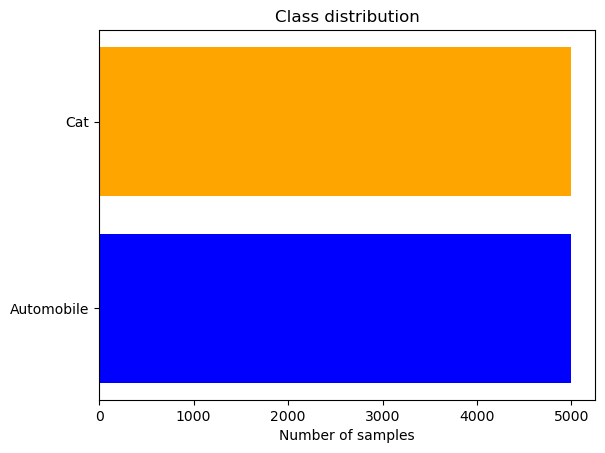

In [6]:
class_names = {0: "Automobile", 1: "Cat"}
plot_class_distribution(cifar_2_train+cifar_2_val, class_names)

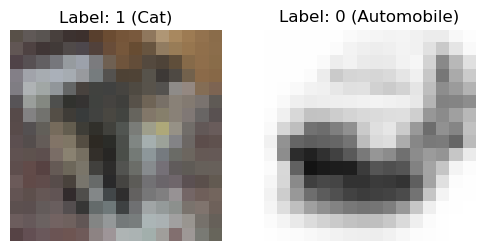

In [7]:
plot_unique_labels(cifar_2_train, class_names)

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;


Write a MyMLP class that implements a MLP in PyTorch (so only fully
connected layers) such that:
    
    - The input dimension is 768(= 16 ∗ 16 ∗ 3) and the output dimension is 2 (for the 2 classes).
    - The hidden layers have respectively 128 and 32 hidden units.
    - All activation functions are ReLU. The last layer has no activation function since the cross-entropy loss already includes a softmax activation
function.

In [8]:
class MyMLP(nn.Module):
    '''
    Class implementing a multi layered perceptron, with
    dimensions: (input: 768) --> (output: 128)
    '''
    def __init__(self):
        # Inherit functionalities from nn.module:
        super().__init__()
        
        # Defining dimensions (determined by img size):
        n_in = 3 * 16 * 16
        n_hidden1 = 128
        n_hidden2 = 32
        n_out = 2

        # Defining layers and activation functions with
        # predefined dimensions:
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(n_in, n_hidden1)
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden2, n_out)

    def forward(self, x):
        '''Model performs a forward pass of x'''
        output = self.flat(x)
        output = self.activation1(self.fc1(output))
        output = self.activation2(self.fc2(output))
        return self.fc3(output)

Write a train(n_epochs, optimizer, model, loss_fn, train_loader) function that trains model for n_epochs epochs given an optimizer optimizer, a loss function loss_fn and a dataloader train_loader.

In [9]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, return_loss=False, verbose=True, GPU_utilize=False):
    '''
    Function for training a neural network using a given optimizer (e.g. SGD).

    Params:
    - n_epochs (int): Number of epochs to train.
    - optimizer (torch.optim.Optimizer): The optimizer used for parameter updates.
    - model (torch.nn.Module): The neural network model to train.
    - loss_fn (callable): The loss function used during training (e.g. CrossEntropyLoss).
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - return_loss (bool): If True, returns a list of average losses per epoch.
    - verbose (bool): If True, prints training progress every 10 epochs and at the end.
    - GPU_utilize (bool): If True, attempts to train on GPU (CUDA or MPS if available).

    Returns:
    - train_losses (list of float, optional): Average training loss per epoch.
    '''
    # If GPU Acceleration available, utilize:
    if GPU_utilize:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
        else:
            print("GPU not available, choosing cpu.")
            device = torch.device('cpu')
    else:
        device = torch.device('cpu')

    if verbose:
        print("Initiating default update train function!")
        
    # Defining start variables s.a. loss list, num_batches,
    # resetting optimizer gradients and initiating training mode:
    train_losses = []
    num_batches = len(train_loader)
    optimizer.zero_grad(set_to_none=True)
    model.train()

    # initiate epoch and batch loops with epoch loss set to 0:
    start_time = t.time()
    for curr_epoch in range(n_epochs):
        curr_loss = 0
        
        for x, y in train_loader:
            x = x.to(device=device, dtype=torch.double) # As instructed in section 3.3
            y = y.to(device=device)
            
            loss = loss_fn(model(x), y) # Compute loss after forward pass
            loss.backward()             # Compute gradients
            optimizer.step()            # Update model with computed gradients
            optimizer.zero_grad()       # Reset gradients
            curr_loss += loss.item()   # Update epoch loss w. batch loss

        train_losses.append(curr_loss / num_batches) # Append the total epoch loss divided by batches

        # If verbosity is true, output:
        if verbose:
            if curr_epoch+1 == 1 or (curr_epoch+1) % 10 == 0:
                print(f"{datetime.now()} | Curr time used: {(t.time()-start_time):.2f}sec | Epoch num: {curr_epoch+1} | Loss: {curr_loss / num_batches}")
            if curr_epoch+1 == n_epochs:
                print("Training done!\n\n")

    if return_loss:
        return train_losses

Write a similar function train manual_update that has no optimizer parameter, but a learning rate lr parameter instead and that manually updates each trainable parameter of model using equation (2). Do not forget to zero out all gradients after each iteration. 

Train 2 instances of MyMLP, one using train and the other using train_manual_update (use the same parameter values for both models). Compare their respective training losses. To get exactly the same results with both functions, see section 3.3

In [10]:
def train_manual_update(n_epochs, model, loss_fn, train_loader, lr=1e-2, momentum_coeff=0., weight_decay=0., return_loss=False,
                        verbose=True, GPU_utilize=False):
    '''
    Function for manually updating network weights while training, implementing
    a simple SGD (with optional momentum and weight decay).

    Params:
    - n_epochs (int): Number of epochs to train.
    - model (torch.nn.Module): The neural network model to train.
    - loss_fn (callable): The loss function used during training.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - lr (float): Learning rate for parameter updates.
    - momentum_coeff (float): Momentum factor (0 <= momentum_coeff < 1).
    - weight_decay (float): Weight decay (L2 regularization) factor (0 <= weight_decay < 1).
    - return_loss (bool): If True, returns a list of average losses per epoch.
    - verbose (bool): If True, prints training progress every 10 epochs and at the end.
    - GPU_utilize (bool): If True, attempts to train on GPU (CUDA or MPS if available).

    Returns:
    - train_losses (list of float, optional): Average training loss per epoch.
    '''
    # If GPU Acceleration available, utilize:
    if GPU_utilize:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
        else:
            print("GPU not available, choosing cpu.")
            device = torch.device('cpu')
    else:
        device = torch.device('cpu')

    if verbose:
        print("Initiating manual update train function!")

    
    # Defining start variables s.a. loss list, num_batches,
    # resetting model gradients, momentum buffer and initiating training mode:
    train_losses = []
    momentum_buffer = [torch.zeros_like(param, device=device, dtype=param.dtype) for param in model.parameters()]
    num_batches = len(train_loader)
    model.train()

    # initiate epoch and batch loops with epoch loss set to 0:
    start_time = t.time()
    for curr_epoch in range(n_epochs):
        curr_loss = 0
        
        for x, y in train_loader:
            x = x.to(device=device, dtype=torch.double) # As instructed in section 3.3
            y = y.to(device=device)
            model.zero_grad()          # Resetting gradients
            
            loss = loss_fn(model(x), y) # Compute loss after forward pass
            loss.backward()             # Compute gradients
    
            with torch.no_grad():
                for i, (buffer, param) in enumerate(zip(momentum_buffer, model.parameters())):
                    gradient = param.grad

                    # Adding L2-regularization:
                    if weight_decay > 0 and weight_decay < 1:
                        gradient = gradient + weight_decay*param.data

                    # Adding Momentum:
                    if momentum_coeff > 0 and momentum_coeff < 1:
                        new_buffer = momentum_coeff * buffer + gradient
                        momentum_buffer[i] = new_buffer
                        gradient = new_buffer
                    
                    # Using equation 3 to update: 
                    # $\theta_t = \theta_{t-1}-\alpha\nabla L(\theta_{t-1})$
                    param.data -= (lr * gradient)
                    
            curr_loss += loss.item()   # Update epoch loss w. batch loss

        train_losses.append(curr_loss / num_batches) # Append the total epoch loss divided by batches

        # If verbosity is true, output:
        if verbose:
            if curr_epoch+1 == 1 or (curr_epoch+1) % 10 == 0:
                print(f"{datetime.now()} | Curr time used: {(t.time()-start_time):.2f}sec | Epoch num: {curr_epoch+1} | Loss: {curr_loss / num_batches}")
            if curr_epoch+1 == n_epochs:
                print("Training done!\n\n")
    
    if return_loss:
        return train_losses


&nbsp;

&nbsp;

&nbsp;


### Comparing Loss Between `train` and `train_manual_update`

From task 3.1.5:
> Train 2 instances of `MyMLP`, one using `train` and the other using `train_manual_update` (use
the same parameter values for both models). Compare their respective training losses. To get
exactly the same results with both functions, see section 3.3.

&nbsp;

**Defining loss comparison functions, dual training function:**

In [11]:
def compare_loss(l_1, l_2, eps):
    '''Compare loss between loss lists'''
    differences = _epsilon_difference(l_1, l_2, eps)
    accumulated_diff = _accumulated_diff(l_1, l_2)
    smallest_l_1, smallest_l_2 = min(l_1), min(l_2)
    print(f"""
    Loss List Comparison:
    ----------------------
    - Is the differences smaller than epsilon ({eps}): {differences}
    - Accumulated difference between loss lists: {accumulated_diff}

    - Smallest loss achieved by model 1: {smallest_l_1}
    - Smallest loss achieved by model 2: {smallest_l_2}
    """)
    

def _epsilon_difference(l_1, l_2, eps):
    '''Private function called by compare_loss to see if list diff is smaller than eps'''
    differences = [True if abs(x-y) < eps else False for x, y in zip(l_1, l_2)]
    return all(differences)
    

def _accumulated_diff(l_1, l_2):
    '''Private function to return accumulated diff between loss lists'''
    return sum(abs(x-y) for x, y in zip(l_1, l_2))
    

def dual_train_and_compare(n_epochs=60, batch_size=64, learning_rate=1e-2, momentum_coeff=0, l2_coeff=0,
                           loss_eps=1e-15, dual=True, return_models=False):
    '''
    Train one or two instances of MyMLP using PyTorch's SGD and/or a manual
    update routine, then compare the resulting losses if both models are trained.

    Params:
    - n_epochs (int): Number of epochs to train each model.
    - batch_size (int): Batch size used in DataLoader.
    - learning_rate (float): Learning rate for training.
    - momentum_coeff (float): Momentum factor (0 <= momentum_coeff < 1).
    - l2_coeff (float): Weight decay factor for L2 regularization (0 <= l2_coeff < 1).
    - loss_eps (float): Epsilon threshold for comparing final losses.
    - dual (bool): If True, trains two models (default and manual) and compares losses.
                   If False, only trains a single model using manual updates.
    - return_models (bool): If True, returns the trained model(s).

    Returns:
    - If return_models=True:
        - If dual=True, returns (MyMLP_default_train, MyMLP_manual_train).
        - Otherwise, returns (MyMLP_manual_train).
      If return_models=False, returns None.
    '''
    # Initiating two classes of type MyMLP with set seed as instructed
    # in section 3.3. aswell as n_epochs and lr:
    if dual:
        torch.manual_seed(seed)
        MyMLP_default_train = MyMLP()
        
        # Initiating optimizer for the default trained MyMLP:
        optimizer = optim.SGD(MyMLP_default_train.parameters(), lr=learning_rate, weight_decay=l2_coeff, momentum=momentum_coeff)
    
    torch.manual_seed(seed)
    MyMLP_manual_train = MyMLP()
    
    # Initiating the dataloader w. shuffle=False for reproducibility:
    train_loader = torch.utils.data.DataLoader(cifar_2_train, batch_size=batch_size, shuffle=False)
    
    # Initiating loss function:
    loss_fn = nn.CrossEntropyLoss()
    
    # Start training on both models w. respective function:
    if dual:
        loss_default_train = train(n_epochs, optimizer, MyMLP_default_train, loss_fn, train_loader, return_loss=True)
    loss_manual_train = train_manual_update(n_epochs, MyMLP_manual_train, loss_fn, train_loader, weight_decay=l2_coeff,
                                              momentum_coeff=momentum_coeff, lr=learning_rate, return_loss=True)

    if dual:
        #Comparing loss
        compare_loss(loss_default_train, loss_manual_train, loss_eps)

    if return_models:
        if dual:
            return MyMLP_default_train, MyMLP_manual_train
        else:
            return MyMLP_manual_train

&nbsp;

**Initiating training and comparing loss:**

In [12]:
dual_train_and_compare(n_epochs=60)

Initiating default update train function!
2025-02-21 10:26:02.865502 | Curr time used: 0.08sec | Epoch num: 1 | Loss: 0.6759217619022266
2025-02-21 10:26:03.350994 | Curr time used: 0.57sec | Epoch num: 10 | Loss: 0.43828589536834245
2025-02-21 10:26:03.866682 | Curr time used: 1.08sec | Epoch num: 20 | Loss: 0.33865909447622905
2025-02-21 10:26:04.385322 | Curr time used: 1.60sec | Epoch num: 30 | Loss: 0.2826931255278965
2025-02-21 10:26:04.898135 | Curr time used: 2.11sec | Epoch num: 40 | Loss: 0.24389811097566635
2025-02-21 10:26:05.410094 | Curr time used: 2.63sec | Epoch num: 50 | Loss: 0.21733284623988916
2025-02-21 10:26:05.934988 | Curr time used: 3.15sec | Epoch num: 60 | Loss: 0.1944395055375672
Training done!


Initiating manual update train function!
2025-02-21 10:26:05.994009 | Curr time used: 0.06sec | Epoch num: 1 | Loss: 0.6759217619022266
2025-02-21 10:26:06.515022 | Curr time used: 0.58sec | Epoch num: 10 | Loss: 0.4382858953683424
2025-02-21 10:26:07.095181 | Curr 

&nbsp;

Thus, we can conclude that the loss is the same.


&nbsp;

&nbsp;

&nbsp;


### Comparing Loss Between `train` and `train_manual_update` w. L2 regularization

From task 3.1.6:
> Modify `train_manual_update` by adding a L2 regularization term in your manual parameter
update. Add an additional weight decay parameter to train manual update. Compare
again train and train manual update results with 0 <weight decay <1.

&nbsp;

**Initiating training to compare loss after adding L2 regularization:**

In [13]:
dual_train_and_compare(n_epochs=60, l2_coeff=1e-4)

Initiating default update train function!
2025-02-21 10:26:09.472396 | Curr time used: 0.06sec | Epoch num: 1 | Loss: 0.675926644200173
2025-02-21 10:26:09.971639 | Curr time used: 0.56sec | Epoch num: 10 | Loss: 0.4385317661877584
2025-02-21 10:26:10.556000 | Curr time used: 1.14sec | Epoch num: 20 | Loss: 0.3389406135986788
2025-02-21 10:26:11.126542 | Curr time used: 1.71sec | Epoch num: 30 | Loss: 0.28304796842779756
2025-02-21 10:26:11.700847 | Curr time used: 2.29sec | Epoch num: 40 | Loss: 0.2441393368232769
2025-02-21 10:26:12.266384 | Curr time used: 2.85sec | Epoch num: 50 | Loss: 0.2177670774352154
2025-02-21 10:26:12.885072 | Curr time used: 3.47sec | Epoch num: 60 | Loss: 0.19505564383652813
Training done!


Initiating manual update train function!
2025-02-21 10:26:12.949180 | Curr time used: 0.06sec | Epoch num: 1 | Loss: 0.675926644200173
2025-02-21 10:26:13.525397 | Curr time used: 0.64sec | Epoch num: 10 | Loss: 0.4385317661877584
2025-02-21 10:26:14.147614 | Curr time

&nbsp;

Thus, we can conclude that the loss is the same.

&nbsp;

&nbsp;

&nbsp;

### Comparing Loss Between `train` and `train_manual_update` w. Momentum

From task 3.1.7:
> Modify `train_manual_update` by adding a L2 regularization term in your manual parameter
update. Add an additional weight decay parameter to train manual update. Compare
again train and train manual update results with 0 <weight decay <1.

&nbsp;

**Initiating training to compare loss after adding momentum:**

In [14]:
dual_train_and_compare(n_epochs=60, momentum_coeff=0.5)

Initiating default update train function!
2025-02-21 10:26:16.718230 | Curr time used: 0.06sec | Epoch num: 1 | Loss: 0.6581971647235336
2025-02-21 10:26:17.240456 | Curr time used: 0.58sec | Epoch num: 10 | Loss: 0.3527253569061587
2025-02-21 10:26:17.821114 | Curr time used: 1.16sec | Epoch num: 20 | Loss: 0.2608193051361419
2025-02-21 10:26:18.401634 | Curr time used: 1.74sec | Epoch num: 30 | Loss: 0.21239752240656118
2025-02-21 10:26:18.959579 | Curr time used: 2.30sec | Epoch num: 40 | Loss: 0.17791574510793864
2025-02-21 10:26:19.561483 | Curr time used: 2.90sec | Epoch num: 50 | Loss: 0.1496621766970712
2025-02-21 10:26:20.145429 | Curr time used: 3.49sec | Epoch num: 60 | Loss: 0.12476573049305581
Training done!


Initiating manual update train function!
2025-02-21 10:26:20.205238 | Curr time used: 0.06sec | Epoch num: 1 | Loss: 0.6581971647235336
2025-02-21 10:26:20.747890 | Curr time used: 0.60sec | Epoch num: 10 | Loss: 0.35272535690615864
2025-02-21 10:26:21.348277 | Curr 

&nbsp;

Thus, we can conclude that the loss is the same.


&nbsp;

&nbsp;

&nbsp;


### Training different instances of `train` and `train_manual_update` w. different hyperparams:

From task 3.1.8:
>  Train different instances (at least 4) of the `MyMLP` model with different learning rate, momentum
and weight decay values. For hyperparameters values, you can find inspiration in the
`gradient_descent_output.txt` file. Note that having different results than in this file is
totally normal (e.g. if you had a different dataset split policy than the one used to create this
file). However, your `train_manual_update` and `train` functions should give exactly the same
results (as we can observe in `gradient_descent_output.txt`)

&nbsp;

**Initializing values and conducting training:**

In [15]:
# initializing global params
n_epochs = 20
batch_size = 64
loss_eps = 1e-13

# Using iterlist to produce all combinations of hyperparams
learning_rates = [0.01, 0.02, 0.1]
weight_decays = [0.01, 0.001, 0.0001]
momentum_list = [0.9, 0.7, 0]
hyperparam_combinations = list(it.product(learning_rates, weight_decays, momentum_list))

# Initiating list for holding trained models:
models = []

# For each combination train with pytorch SGD and manual update:
for i, combination in enumerate(hyperparam_combinations):
    learning_rate, weight_decay, momentum_coeff = combination[0], combination[1], combination[2]
    print(f"\n---------- Hyperparam combination {i+1} ----------")
    print(f"- Learning rate: {learning_rate} \n- Weight decay: {weight_decay} \n- Momentum coeff.: {momentum_coeff}\n\n\n")
    
    model = dual_train_and_compare(n_epochs=n_epochs, batch_size=batch_size, learning_rate=learning_rate,
                                   momentum_coeff=momentum_coeff, l2_coeff=weight_decay, loss_eps=loss_eps,
                                   dual=False, return_models=True)
    print(f"----------------------------------------------\n\n\n")
    
    # Append model with name and params:
    models.append((model, "manual update", combination))


---------- Hyperparam combination 1 ----------
- Learning rate: 0.01 
- Weight decay: 0.01 
- Momentum coeff.: 0.9



Initiating manual update train function!
2025-02-21 10:26:23.895559 | Curr time used: 0.07sec | Epoch num: 1 | Loss: 0.5665733957127194
2025-02-21 10:26:24.537163 | Curr time used: 0.71sec | Epoch num: 10 | Loss: 0.3094579599903425
2025-02-21 10:26:25.246247 | Curr time used: 1.42sec | Epoch num: 20 | Loss: 0.2782106429484477
Training done!


----------------------------------------------




---------- Hyperparam combination 2 ----------
- Learning rate: 0.01 
- Weight decay: 0.01 
- Momentum coeff.: 0.7



Initiating manual update train function!
2025-02-21 10:26:25.318455 | Curr time used: 0.07sec | Epoch num: 1 | Loss: 0.6344814438671895
2025-02-21 10:26:25.949901 | Curr time used: 0.70sec | Epoch num: 10 | Loss: 0.3270450499012421
2025-02-21 10:26:26.676971 | Curr time used: 1.43sec | Epoch num: 20 | Loss: 0.2599397849703759
Training done!


----------------------

### Selecting the best trained model and analyzing its performance:

From task 3.1.9:
>  Select the best model among those trained in the previous question based on their accuracy.

From task 3.1.10:
> Evaluate the best model and analyse its performance.

&nbsp;

**Selecting the best trained model:**

In [16]:
def select_best_model(list_of_models):
    '''Function for selecting best model'''
    # Init values:
    best_performing_model = None
    best_params = None
    best_name = None
    best_accuracy = 0

    # Initializing dataloader:
    loader = torch.utils.data.DataLoader(cifar_2_val, batch_size=batch_size, shuffle=False)

    # For each model in list of models compute
    # accuracy, if best, switch out current best
    for model, name, params in list_of_models:
        accuracy = compute_accuracy(model, loader)
        
        if accuracy > best_accuracy:
            best_performing_model = model
            best_params = params
            best_name = name
            best_accuracy = accuracy

    print(f"""
    Best performing model:
    - Type of update: {best_name}
    
    - Params:
     -- Learning rate: {params[0]}
     -- Weight decay: {params[1]}
     -- Momentum coeff.: {params[2]}

    - Accuracy: {best_accuracy}
     """)
    return best_performing_model

best_performing_model = select_best_model(models)


    Best performing model:
    - Type of update: manual update
    
    - Params:
     -- Learning rate: 0.1
     -- Weight decay: 0.0001
     -- Momentum coeff.: 0

    - Accuracy: 0.9064089521871821
     


&nbsp;

**Evaluating its performance:**

In [17]:
def evaluate_best_performing_model(model):
    '''Function for selecting best model'''
    # Initializing dataloader:
    loader = torch.utils.data.DataLoader(cifar_2_test, batch_size=batch_size, shuffle=False)
    accuracy = compute_accuracy(model, loader)


    print(f"""
    Evaluating our best performing model:
    
    - Accuracy on unseen test data: {accuracy}
     """)
    return accuracy

accuracy_on_test = evaluate_best_performing_model(best_performing_model)


    Evaluating our best performing model:
    
    - Accuracy on unseen test data: 0.896
     
